In [1]:
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
################################################################################
##                           LEER DATOS SERIE                                 ##
################################################################################

class TimeSeriesNN3():
    def __init__(self,STEPS_AHEAD ,NUMBER_TESTING ,PERCENTAGE_VALIDATION, SERIE, WINDOW):
        self.STEPS_AHEAD = STEPS_AHEAD
        self.WINDOW = WINDOW
        self.NUMBER_TESTING = NUMBER_TESTING
        self.PERCENTAGE_VALIDATION = PERCENTAGE_VALIDATION
        self.SERIE = SERIE
        self.SIZE = SERIE.shape[0]
        self.NUMBER_VALIDATION = 0
        self.NUMBER_TRAINING = self.SIZE - self.NUMBER_TESTING
        if (PERCENTAGE_VALIDATION != 0):
            self.NUMBER_VALIDATION = int(self.NUMBER_TRAINING/self.PERCENTAGE_VALIDATION)
        self.NUMBER_TRAINING_F = self.NUMBER_TRAINING - self.NUMBER_VALIDATION - self.WINDOW
    
    def divide_testing (self):
        return (self.SERIE[:self.NUMBER_TRAINING],self.SERIE[self.NUMBER_TRAINING:])
    
    def divide_validation (self,serie, random):
        experimentx = np.zeros((self.NUMBER_TRAINING - self.WINDOW , self.WINDOW))
        experimenty = np.zeros((self.NUMBER_TRAINING - self.WINDOW,1))
        cnt =  0
        cnt2 = 0
        for i in range (experimentx.shape[0]):
            cnt += cnt2
            for j in range (self.WINDOW):
                experimentx[i][j] = self.SERIE[cnt]
                cnt += 1
            experimenty[i] = self.SERIE[cnt + self.STEPS_AHEAD - 1]
            cnt = 0
            cnt2 += 1      
        if (random):
            experimentx = np.concatenate((experimentx, experimenty), axis=1)
            experimentx = np.random.permutation(experimentx)
            experimentx, experimenty = np.hsplit(experimentx,[-1])   
        
        if (self.PERCENTAGE_VALIDATION == 0):
            return (experimentx, experimenty, experimentx, experimenty)
        else:
            return (experimentx[:self.NUMBER_TRAINING_F], experimenty[:self.NUMBER_TRAINING_F], experimentx[self.NUMBER_TRAINING_F:], experimenty[self.NUMBER_TRAINING_F:])
    
    
    def batch (self, boolean):
        x,p = self.divide_testing()
        w,x,y,z =self.divide_validation(x,boolean)
        return (w,x,y,z,p)
            

            

In [3]:
################################################################################
##                           GRAPH DEFINITION                                 ##
################################################################################

PERCENTAGE_VALIDATION = 10
NUMBER_TESTING        = 18
STEPS_AHEAD           = 1
WINDOW = 5
training_data = pd.read_excel("NN3_FINAL_DATASET_WITH_TEST_DATA.xlsx",sheet_name="Hoja 1")
Serie_1 = training_data["Serie 11"]
Serie_1_ORIGINAL = training_data["Serie 11"]

MAXIMO = np.amax(Serie_1)
Serie_1 = Serie_1/np.amax(Serie_1)
ACTIVATION =  tf.nn.relu
#print(Serie_1, Serie_1/np.amax(Serie_1),np.amax(Serie_1))

INPUT_SIZE    = WINDOW      
RNN_HIDDEN1    = 10
RNN_HIDDEN2    = 10
RNN_HIDDEN3    = 1
OUTPUT_SIZE   = 1       # 1 bit per timestep
LEARNING_RATE = 0.1
#n_layers      = 3
EPOCH         = 20

Serie1 = TimeSeriesNN3(STEPS_AHEAD ,NUMBER_TESTING ,PERCENTAGE_VALIDATION, Serie_1,WINDOW)
tx,ty,vx,vy,p = Serie1.batch(False)

X = tf.placeholder(tf.float32,[None,INPUT_SIZE,1])
Y = tf.placeholder(tf.float32, (None,INPUT_SIZE,1))



#cellForm = [tf.contrib.rnn.BasicLSTMCell(RNN_HIDDEN1, activation = ACTIVATION),tf.contrib.rnn.BasicLSTMCell(RNN_HIDDEN2, activation = ACTIVATION),tf.contrib.rnn.BasicLSTMCell(RNN_HIDDEN3, activation = ACTIVATION)]
cellForm = [tf.contrib.rnn.BasicLSTMCell(RNN_HIDDEN1, activation = ACTIVATION)]
cell= tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.MultiRNNCell(cellForm),output_size=OUTPUT_SIZE )
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(outputs - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()



################################################################################
##                           TRAINING LOOP                                    ##
################################################################################

prediction          = []
MSE_grap            = np.zeros(EPOCH)
n_iterations        = tx.shape[0] 
size_validation     = vx.shape[0]
with tf.Session() as sess:
    init.run()
    for epoch in range (EPOCH):
        mse = 0
        for iteration in range(n_iterations):
            X_batch, Y_batch = tx[iteration], ty[iteration]
            X_batch = X_batch.reshape(1,INPUT_SIZE,1)
            Y_batch = Y_batch.reshape(1,1)
            Y_batch = np.concatenate((X_batch.reshape(1,INPUT_SIZE)[:,1:], Y_batch), axis=1)
            Y_batch = Y_batch.reshape(1,INPUT_SIZE,1)
            sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
            #print(outputs.eval(feed_dict={X: X_batch, Y: Y_batch}))
            #print(Y.eval(feed_dict={X: X_batch, Y: Y_batch}))
            
        for iteration in range(size_validation):
            vv1, vv2 = vx[iteration], vy[iteration]
            vv1 = vv1.reshape(1,INPUT_SIZE,1)
            vv2 = vv2.reshape(1,1)
            vv2 = np.concatenate((vv1.reshape(1,INPUT_SIZE)[:,1:], vv2), axis=1)
            vv2 = vv2.reshape(1,INPUT_SIZE,1)
            mse += loss.eval(feed_dict={X: vv1, Y: vv2})
            prediction.append(outputs.eval(feed_dict={X: vv1, Y: vv2})[:,-1,:])
        
        tx = np.concatenate((tx, ty), axis=1)
        tx = np.random.permutation(tx)
        tx, ty = np.hsplit(tx,[-1])
        print(epoch, "\tMSE:", mse/size_validation)
        MSE_grap [epoch] = mse/size_validation

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
0 	MSE: 0.028054391499608755
1 	MSE: 0.02382799657061696
2 	MSE: 0.02377291574763755
3 	MSE: 0.017746652631709974
4 	MSE: 0.014391148967357973
5 	MSE: 0.021195428756376106
6 	MSE: 0.011410519926963994
7 	MSE: 0.020223438429335754
8 	MSE: 0.032727257503817477
9 	MSE: 0.025811975821852684
10 	MSE: 0.020785350895797212
11 	MSE: 0.023858147362867992
12 	MSE: 0.014505638896177212
13 	MSE: 0.013780068179282049
14 	MSE: 0.015554743935354054
15 	MSE: 0.025892700379093487
16 	MSE: 0.013561728332812587
17 	MSE: 0.02951046001786987
18 	MSE: 0.011093253813063106
19 	MSE: 0.026338604046031833


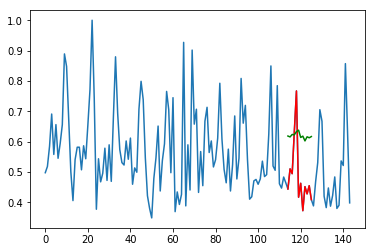

In [4]:
pp = np.array(prediction[-Serie1.NUMBER_VALIDATION:])
pp = pp.reshape([Serie1.NUMBER_VALIDATION,1])
plt.plot(Serie_1)
plt.plot(np.arange(Serie1.NUMBER_TRAINING_F+Serie1.WINDOW,Serie1.NUMBER_TRAINING),vy.reshape(Serie1.NUMBER_VALIDATION),"r")
plt.plot(np.arange(Serie1.NUMBER_TRAINING_F+Serie1.WINDOW,Serie1.NUMBER_TRAINING),pp[-Serie1.NUMBER_VALIDATION:],"g")
plt.show()

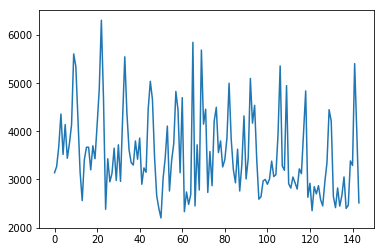

In [5]:
pp = np.array(prediction[-Serie1.NUMBER_VALIDATION:])
pp = pp.reshape([Serie1.NUMBER_VALIDATION,1])
plt.plot(Serie_1_ORIGINAL)
#plt.plot(np.arange(Serie1.NUMBER_TRAINING_F+Serie1.WINDOW,Serie1.NUMBER_TRAINING),vy.reshape(Serie1.NUMBER_VALIDATION)*MAXIMO,"r")
#plt.plot(np.arange(Serie1.NUMBER_TRAINING_F+Serie1.WINDOW,Serie1.NUMBER_TRAINING),pp[-Serie1.NUMBER_VALIDATION:]*MAXIMO,"g")
plt.show()

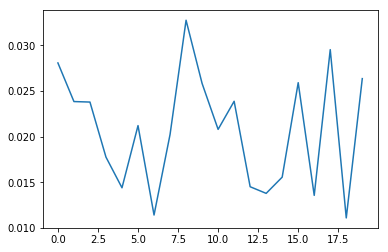

In [6]:
plt.plot(MSE_grap)
plt.show()

In [7]:
X_batch, Y_batch = tx[0], ty[0]
X_batch = X_batch.reshape(1,INPUT_SIZE,1)
Y_batch = Y_batch.reshape(1,1)
Y_batch = np.concatenate((X_batch.reshape(1,INPUT_SIZE)[:,1:], Y_batch), axis=1)


In [8]:
print (X_batch, Y_batch)


[[[0.47543582]
  [0.45958796]
  [0.4770206 ]
  [0.53565769]
  [0.48494453]]] [[0.45958796 0.4770206  0.53565769 0.48494453 0.49128368]]


In [9]:
ty[0]

array([0.49128368])